In [51]:
%matplotlib inline
import math, numpy as np, tensorflow as tf, matplotlib.pyplot as plt, operator
from importlib import reload

# Clustering

In [3]:
import kmeans; reload(kmeans)
from kmeans import Kmeans

In [4]:
n_clusters=6
n_samples =250

In [30]:
centroids = np.random.uniform(-35, 35, (n_clusters, 2))
slices = [np.random.multivariate_normal(centroids[i], np.diag([5., 5.]), n_samples)
           for i in range(n_clusters)]
data = np.concatenate(slices).astype(np.float32)

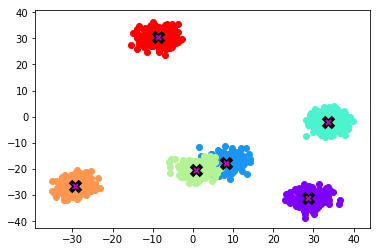

In [31]:
kmeans.plot_data(centroids, data, n_samples)

## K means

In [53]:
k = Kmeans(data, n_clusters)

In [54]:
with tf.Session().as_default():
    new_centroids = k.run()

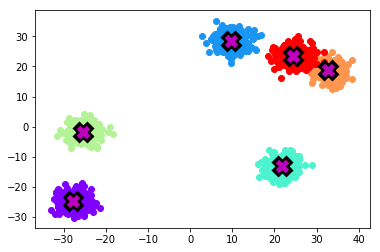

In [55]:
kmeans.plot_data(new_centroids, data, n_samples)

## Mean shift

In [237]:
def gaussian(d, bw):
    return np.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [272]:
def meanshift(data):
    X = np.copy(data)
    for it in range(5):
        for i, x in enumerate(X):
            dist = np.sqrt(((x-X)**2).sum(1))
            weight = gaussian(dist, 2.5)
            X[i] = (np.expand_dims(weight,1)*X).sum(0) / weight.sum()
    return X

In [273]:
%time X=meanshift(data)

CPU times: user 1 s, sys: 8 ms, total: 1.01 s
Wall time: 1.01 s


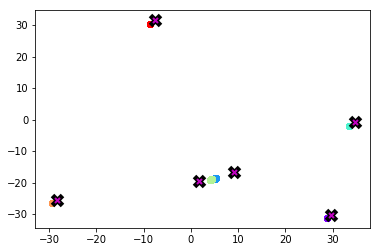

In [274]:
kmeans.plot_data(centroids+1, X, n_samples)

## PyTorch

In [59]:
import torch_utils; reload(torch_utils)
from torch_utils import *

In [202]:
def gaussian(d, bw):
    return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [275]:
def meanshift(data):
    X = torch.FloatTensor(np.copy(data))
    for it in range(5):
        for i, x in enumerate(X):
            dist = torch.sqrt((sub(x, X)**2).sum(1))
            weight = gaussian(dist, 3)
            num = mul(weight, X).sum(0)
            X[i] = num / weight.sum()
    return X

In [277]:
%time X = meanshift(data).numpy()

CPU times: user 1.38 s, sys: 0 ns, total: 1.38 s
Wall time: 1.38 s


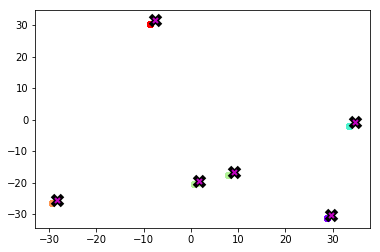

In [217]:
kmeans.plot_data(centroids+1, X, n_samples)

### GPU

In [201]:
a=torch.rand(2,2)
b=torch.rand(3,2)
dist_b(b, a).squeeze(2)


 0.6196  0.4259  0.5988
 0.8464  0.4405  0.8611
[torch.FloatTensor of size 2x3]

In [199]:
def dist_b(a,b):
    return torch.sqrt((sub(a.unsqueeze(0),b.unsqueeze(1))**2).sum(2))

In [202]:
def gaussian(d, bw):
    return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [278]:
def sum_sqz(a,axis): return a.sum(axis).squeeze(axis)

In [304]:
def meanshift(data, bs=500):
    n = len(data)
    X = torch.FloatTensor(np.copy(data)).cuda()
    for it in range(5):
        for i in range(0,n,bs):
            s = slice(i,min(n,i+bs))
            weight = gaussian(dist_b(X, X[s]), 2)
            num = sum_sqz(mul(weight, X), 1)
            X[s] = div(num, sum_sqz(weight, 1))
    return X

In [308]:
%time X = meanshift(data).cpu().numpy()

CPU times: user 48 ms, sys: 4 ms, total: 52 ms
Wall time: 48.2 ms


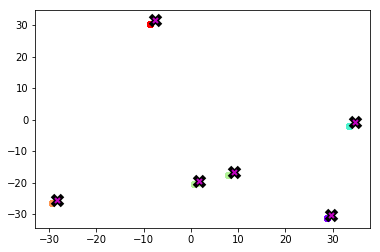

In [290]:
kmeans.plot_data(centroids+1, X, n_samples)